# 1. Load Data & Inspect Structure

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer

sns.set(style="whitegrid")

train_df = pd.read_csv("data/train.csv", index_col=0)
test_df = pd.read_csv("data/test.csv", index_col=0)

train_df.head(), train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    40000 non-null  object
 1   author  40000 non-null  object
dtypes: object(2)
memory usage: 937.5+ KB


(                                                text author
 0   Hardy, Thomas Sutton,\nChristopher Moody_, an...  defoe
 1   To the vest was a\ngirdle five or six inches ...  defoe
 2  \n\nAmy was concerned at it as well as I, but ...  defoe
 3   "Well," said I, "thou art very kind, but this...  defoe
 4  \n\n“Now, Friday,” says I, laying down the dis...  defoe,
 None)

- The training set contains 40,000 samples.
- There are no missing values in either text or author.
- The dataset consists of two relevant fields:
  - text – the fragment of writing
  - author – the label to predict
- All columns are appropriately typed (object), as expected for raw text.

# 2. Class Distribution

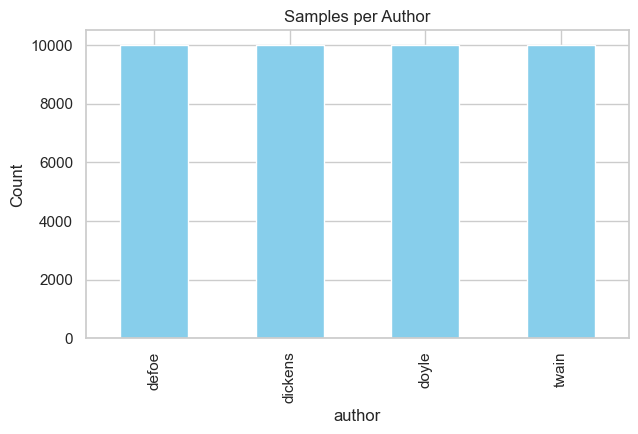

In [2]:
plt.figure(figsize=(7,4))
train_df['author'].value_counts().plot(kind='bar', color='skyblue')
plt.title("Samples per Author")
plt.ylabel("Count")
plt.show()

The bar plot shows:

- Defoe, Dickens, Doyle, and Twain each contribute approximately the same number of samples.

This tells us:

- The dataset is class-balanced.
- A simple classifier will not need class weighting or resampling methods.
- Accuracy and macro-F1 will be meaningful metrics for evaluation.

# 3. Text Length Analysis (Character & Word Counts)

In [3]:
train_df['char_len'] = train_df['text'].str.len()
train_df['word_count'] = train_df['text'].str.split().str.len()

train_df[['char_len', 'word_count']].describe()

,char_len,word_count
count,40000.000000,40000.000000
mean,317.323825,57.781750
std,140.878538,25.986131
min,200.000000,12.000000
25%,231.000000,42.000000
50%,273.000000,50.000000
75%,349.000000,64.000000
max,3289.000000,569.000000


These statistics show that the text fragments vary widely in length.
On average, each sample contains ~317 characters and ~58 words, with most fragments falling between 42–64 words.

A few excerpts are much longer (up to 569 words), while the shortest are around 12 words.

# 4. Global Word Count Analysis

In [4]:
import re
from collections import Counter

# simple tokenizer: split on non-letters
def tokenize(text):
    return re.findall(r"[A-Za-z]+", text.lower())

all_tokens = []

for txt in train_df["text"]:
    all_tokens.extend(tokenize(txt))

total_tokens = len(all_tokens)
unique_tokens = len(set(all_tokens))
ttr = unique_tokens / total_tokens

total_tokens, unique_tokens, ttr

(2339021, 36887, 0.015770273118539766)

Total Tokens: 2,339,021
Unique Tokens (Vocabulary Size): 36,887
Type–Token Ratio (TTR): 0.01577


- Token count is large (≈2.34 million words)
- Vocabulary Size ~36.9k words - This is typical for 18th–19th century English prose
- Low Type–Token Ratio (~1.6%). A TTR of ~0.016 indicates:
  - A large corpus
  - A long-tail vocabulary distribution
  - Significant repetition of high-frequency function words
  - Many rare words (confirmed below)

# 5. Most and Least Common Words

In [5]:
word_freq = Counter(all_tokens)
word_freq.most_common(20)

[('the', 121279),
 ('and', 85989),
 ('to', 64887),
 ('of', 62478),
 ('a', 52531),
 ('i', 51776),
 ('in', 38315),
 ('it', 35795),
 ('that', 35362),
 ('was', 31779),
 ('he', 28991),
 ('his', 21635),
 ('you', 21146),
 ('as', 19924),
 ('with', 19315),
 ('for', 19104),
 ('had', 18255),
 ('but', 16526),
 ('is', 15479),
 ('not', 15290)]

The result reflects the dominance of high-frequency English function words.

- Words like the, and, to, of, a, i, in appear extremely often. This is normal and expected.

In [6]:
list(word_freq.items())[-20:]

[('pawed', 1),
 ('confessions', 1),
 ('possessors', 1),
 ('pansy', 1),
 ('awready', 1),
 ('borry', 1),
 ('lafe', 1),
 ('buckner', 1),
 ('ghizeh', 1),
 ('itaska', 1),
 ('ibex', 1),
 ('mysteriousness', 1),
 ('stacking', 1),
 ('briefer', 1),
 ('costumed', 1),
 ('capuchin', 1),
 ('pervasive', 1),
 ('chancel', 1),
 ('hezekiah', 1),
 ('nimrod', 1)]

Large number of hapax legomena (words appearing once).
- This is a hallmark of natural language corpora - especially multi-author literary datasets.

# 6. Distribution of Text Length per Author

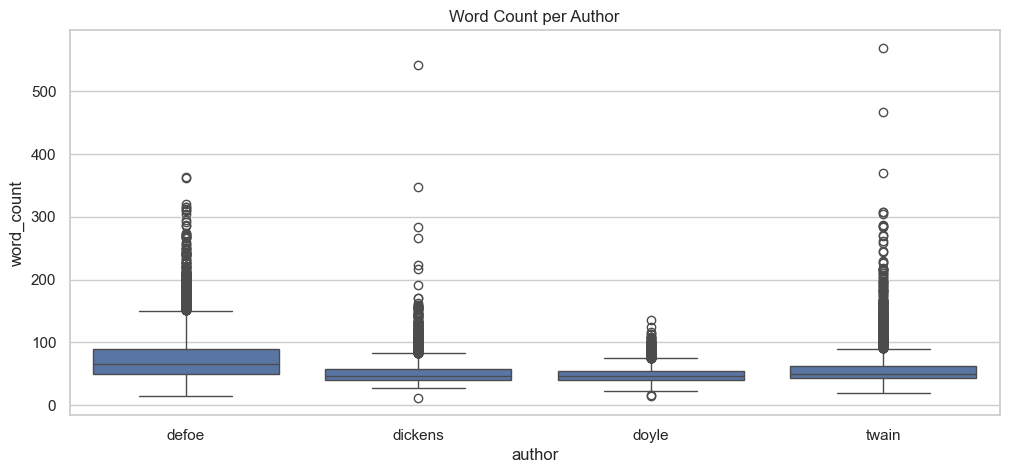

In [7]:
plt.figure(figsize=(12,5))
sns.boxplot(x='author', y='word_count', data=train_df)
plt.title("Word Count per Author")
plt.show()

This boxplot shows how the length of text fragments varies by author.
A few patterns stand out:

- Defoe tends to have the longest fragments on average, with a noticeably higher median and many high-end outliers.
- Dickens and Twain have moderate-length fragments with somewhat similar distributions.
- Doyle generally writes the shortest and most compact fragments among the four.

Although all authors show some long outliers (typical of descriptive or dialogue-heavy passages), the differences in their medians and overall spread suggest that fragment length carries useful stylistic information for author classification.

# 7. Sentence Structure Analysis

In [8]:
def count_sentences(text):
    return len(re.split(r"[.!?]+", text)) - 1

train_df['sentence_count'] = train_df['text'].apply(count_sentences)
train_df['avg_words_per_sentence'] = (
    train_df['word_count'] / train_df['sentence_count'].replace(0, 1)
)

train_df[['sentence_count', 'avg_words_per_sentence']].describe()

,sentence_count,avg_words_per_sentence
count,40000.000000,40000.000000
mean,2.021275,39.939708
std,2.026321,30.529754
min,0.000000,1.012048
25%,1.000000,17.000000
50%,2.000000,35.333333
75%,3.000000,53.000000
max,83.000000,370.000000


These metrics summarize how many sentences each fragment contains and how long those sentences typically are.

- A typical fragment contains about 2 sentences, with most falling between 1 and 3 sentences.
- The average sentence length is ~40 words, though there is substantial variation across samples.
- Some fragments have very long sentences (up to 370 words), which is characteristic of older literary styles.

Overall, the dataset exhibits a wide range of sentence structures—from short, concise sentences to long, multi-clause ones.

# 8. Sentence Patterns per Author

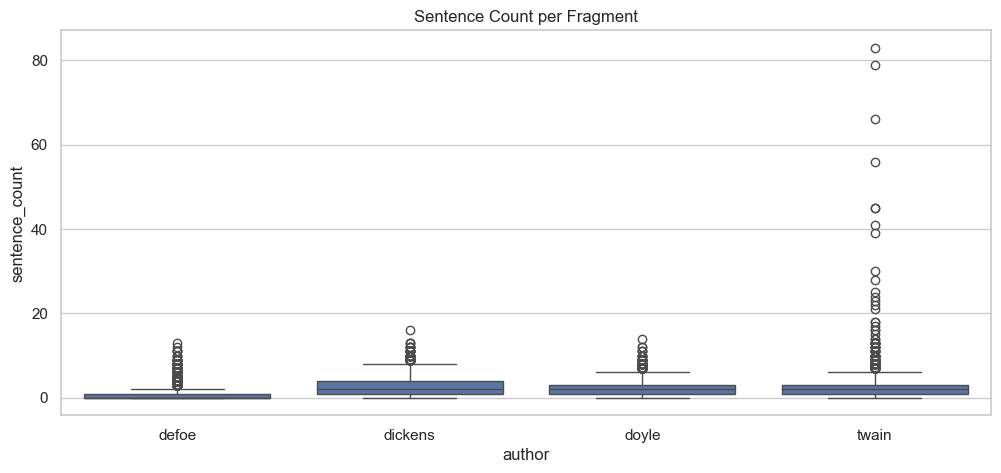

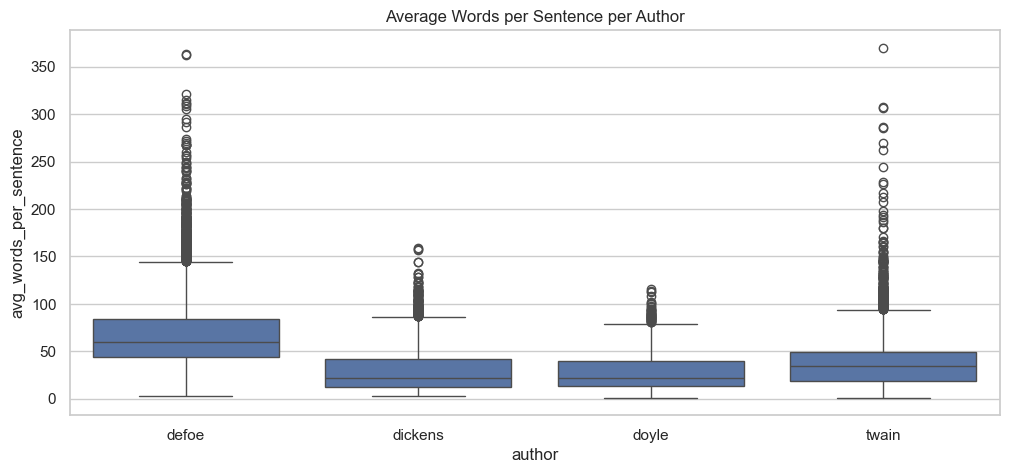

In [9]:
plt.figure(figsize=(12,5))
sns.boxplot(x='author', y='sentence_count', data=train_df)
plt.title("Sentence Count per Fragment")
plt.show()

plt.figure(figsize=(12,5))
sns.boxplot(x='author', y='avg_words_per_sentence', data=train_df)
plt.title("Average Words per Sentence per Author")
plt.show()

This plot shows how many sentences appear in each text fragment for each author.

- Defoe, Dickens, and Doyle mostly produce fragments containing 1–3 sentences, with relatively similar distributions.
- Twain shows the widest spread, including a noticeable number of fragments with 10+ sentences, and a few extreme outliers above 50 sentences.

Overall, sentence count varies across authors, and the broader range in Twain’s writing provides a potentially useful stylistic cue.

# 9. Punctuation Usage

In [10]:
punctuations = [",", ".", ";", ":", "!", "?", "\"", "'", "—"]
for p in punctuations:
    train_df[f"p_{p}"] = train_df["text"].apply(lambda x: x.count(p))

train_df[[f"p_{p}" for p in punctuations]].describe()

,"p_,",p_.,p_;,p_:,p_!,p_?,"p_""",p_',p_—
count,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,5.055050,1.536975,0.620200,0.098975,0.216625,0.268450,0.102250,0.337000,0.081225
std,3.543238,1.600421,1.030232,0.340928,0.674804,0.650957,0.770461,1.137679,0.404514
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,62.000000,82.000000,17.000000,6.000000,21.000000,9.000000,17.000000,22.000000,20.000000


This table shows the overall distribution of punctuation marks across all text fragments. On average, each fragment contains:

- ≈ 5 commas, making commas the most common punctuation in the dataset
- ≈ 1.5 periods, consistent with the median fragment having about two sentences
- fewer semicolons, colons, exclamation marks, and em-dashes, each typically appearing 0–1 times per fragment

The maximum values show that some fragments contain unusually high counts of certain punctuation marks (e.g., up to 82 periods or 62 commas), which corresponds to exceptionally long or dialogue-heavy excerpts.

Overall, this step confirms that punctuation appears frequently enough to serve as a meaningful feature in later author classification.

# 10. Punctuation Heatmap by Author

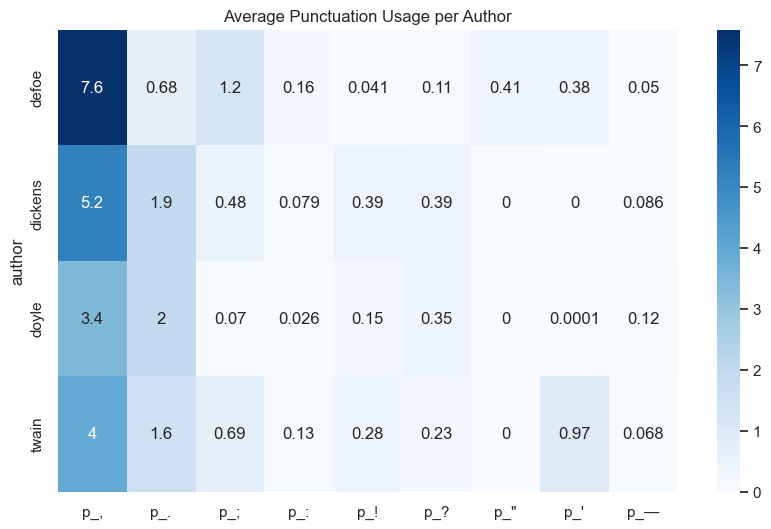

In [11]:
punct_cols = [f"p_{p}" for p in punctuations]

plt.figure(figsize=(10,6))
sns.heatmap(train_df.groupby("author")[punct_cols].mean(), annot=True, cmap="Blues")
plt.title("Average Punctuation Usage per Author")
plt.show()

This heatmap shows clear stylistic differences in how each author uses punctuation:

- Defoe uses the most commas (7.6 per fragment) and a relatively high number of semicolons.
- Dickens uses more periods and quotation marks.
- Doyle uses the least punctuation overall, especially semicolons and em-dashes.
- Twain uniquely uses far more apostrophes (0.97) and a moderate number of em-dashes.

Overall, the punctuation profiles differ in ways that align closely with each author’s known narrative style. This makes punctuation a strong and interpretable feature for authorship classification.

# 11. Lexical Style: Common Words per Author

In [12]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

stop = set(stopwords.words("english"))

def top_words(texts, n=20):
    words = " ".join(texts).lower().split()
    words = [w for w in words if w.isalpha() and w not in stop]
    return Counter(words).most_common(n)

authors = train_df["author"].unique()

for a in authors:
    print(f"\n---- {a} ----")
    print(top_words(train_df[train_df["author"] == a]["text"]))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ashfaqsalehin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



---- defoe ----
[('would', 2942), ('upon', 2538), ('one', 2317), ('could', 2100), ('two', 1441), ('great', 1429), ('came', 1416), ('made', 1403), ('much', 1249), ('people', 1171), ('go', 1144), ('time', 1110), ('might', 1094), ('said', 1091), ('little', 1034), ('come', 1014), ('may', 984), ('good', 984), ('man', 980), ('went', 974)]

---- dickens ----
[('said', 4072), ('mr', 1756), ('would', 1258), ('little', 1149), ('upon', 1108), ('one', 1048), ('old', 913), ('know', 879), ('could', 865), ('never', 735), ('like', 722), ('replied', 693), ('much', 686), ('man', 671), ('miss', 669), ('made', 650), ('come', 643), ('see', 609), ('good', 602), ('looked', 587)]

---- doyle ----
[('upon', 2016), ('said', 1930), ('one', 1547), ('would', 1524), ('could', 1333), ('man', 985), ('holmes', 946), ('see', 833), ('little', 829), ('us', 788), ('may', 781), ('must', 715), ('two', 635), ('came', 626), ('know', 603), ('come', 595), ('think', 568), ('shall', 558), ('back', 515), ('might', 511)]

---- twa

The most frequent content words reveal clear and meaningful stylistic differences between the authors:

- Defoe: Uses many modal verbs (would, could, might, may) and action words (came, made, went, go).
This reflects his descriptive, event-driven narrative style.
- Dickens: Dominated by dialogue markers and social titles such as said, mr, miss, replied. Dickens’s writing is character-centric and conversational, and the vocabulary reflects heavy use of dialogue and social interactions.
- Doyle: Shows strong presence of the name Holmes, along with deductive verbs (must, think, know). This matches the analytical style of detective fiction, where reasoning, inference, and the Holmes character are central.
- Twain: Contains more colloquial verbs (got, like, get) and informal expressions.

Across all authors, recurring words like one, would, could, little appear but in different proportions and contexts. These vocabulary patterns strongly support the idea that lexical choice carries significant stylistic information useful for authorship classification.

# 12. Character-level N-grams

In [13]:
vectorizer = TfidfVectorizer(analyzer="char", ngram_range=(3,3), max_features=5000)
X = vectorizer.fit_transform(train_df["text"])
char_ngrams = vectorizer.get_feature_names_out()

char_ngrams[:20]

array(['\n--', '\na ', '\nab', '\nac', '\nad', '\naf', '\nag', '\nal',
       '\nam', '\nan', '\nap', '\nar', '\nas', '\nat', '\naw', '\nba',
       '\nbe', '\nbi', '\nbl', '\nbo'], dtype=object)

The first character trigrams mainly consist of newline characters followed by letters (e.g., '\n--', '\na '). This reflects the formatting and how fragments begin in the dataset.

Even though these look simple, character n-grams still capture useful stylistic patterns such as punctuation habits, spacing, and common letter sequences—signals that often help distinguish authors more reliably than word-level features alone.

# 14. Word-level N-grams

In [14]:
vectorizer_w = TfidfVectorizer(analyzer="word", ngram_range=(2,2), max_features=5000)
Xw = vectorizer_w.fit_transform(train_df["text"])
word_ngrams = vectorizer_w.get_feature_names_out()

word_ngrams[:20]

array(['able to', 'about and', 'about as', 'about half', 'about her',
       'about him', 'about his', 'about in', 'about it', 'about me',
       'about my', 'about that', 'about the', 'about them', 'about this',
       'about three', 'about to', 'about two', 'above all', 'above the'],
      dtype=object)

The most frequent word bigrams are common connective phrases such as “able to”, “about the”, and “about him”. These represent typical English sentence structures rather than author-specific expressions.

While the top bigrams are generic, the full set of 5000 includes many more distinctive combinations—capturing phrasing patterns, idioms, and stylistic choices that help the model differentiate authors more effectively than single words alone.

# 15. Final Notes on Modeling Approaches

Based on the exploratory analysis, this project primarily benefits from a classical machine learning approach, since the authorship signal is strongly tied to:

- punctuation habits,
- sentence structure,
- character-level patterns, and
- repeated lexical phrases.

These stylistic cues are captured exceptionally well by TF-IDF features combined with a linear classifier, which is efficient and interpretable.

However, to provide a more complete exploration, I will also train a second, deep-learning model for comparison. This demonstrates the ability to evaluate different modeling paradigms:

1. ML-Based Pipeline (Primary Approach)

   TF-IDF (word + character n-grams) → Linear SVM

   - Fast to train
   - Well-suited for sparse, stylistic features
   - Very strong baseline for authorship attribution
   - Expected to deliver the best performance on this dataset

3. Deep Learning Approach (Secondary Exploration)

   DistilBERT fine-tuning for text classification

   - Captures contextual word representations
   - Serves as a modern alternative model
   - Useful for comparing semantic vs. stylistic modeling approaches